In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/emotion-dataset")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████| 715k/715k [00:01<00:00, 558kB/s]

Extracting files...
Path to dataset files: C:\Users\Srimanth\.cache\kagglehub\datasets\parulpandey\emotion-dataset\versions\1


In [10]:
import os
import pandas as pd
dataset_dir = path  

csv_file = [file for file in os.listdir(dataset_dir) if file.endswith('.csv')]

if csv_file:
    df = pd.read_csv(os.path.join(dataset_dir, csv_file[0]))
    print(df)
else:
    print("No CSV file found in the dataset.")

                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never make her separate from me because i do...      0
3     i left with my bouquet of red and yellow tulip...      1
4       i was feeling a little vain when i did this one      0
...                                                 ...    ...
1995  i just keep feeling like someone is being unki...      3
1996  im feeling a little cranky negative after this...      3
1997  i feel that i am useful to my people and that ...      1
1998  im feeling more comfortable with derby i feel ...      1
1999  i feel all weird when i have to meet w people ...      4

[2000 rows x 2 columns]


sadness (0), joy (1), love (2), anger (3), fear (4).

In [15]:

!pip install deep-translator


     -------------------------------------- 42.3/42.3 kB 340.9 kB/s eta 0:00:00


In [17]:
import pandas as pd
from deep_translator import GoogleTranslator
import random
from tqdm import tqdm
languages = ['es', 'fr', 'de', 'hi', 'zh-CN'] 

def translate_back_and_forth(text):
    lang = random.choice(languages)
    translated = GoogleTranslator(source='en', target=lang).translate(text)
    back_translated = GoogleTranslator(source=lang, target='en').translate(translated)
    
    return back_translated

augmented_texts = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    original_text = row['text']
    augmented_text = translate_back_and_forth(original_text)
    augmented_texts.append(augmented_text)
df_augmented = df.copy()
df_augmented['text'] = augmented_texts

df_combined = pd.concat([df, df_augmented], ignore_index=True)

print(df_combined)


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:06:58<00:00,  2.01s/it]

                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never make her separate from me because i do...      0
3     i left with my bouquet of red and yellow tulip...      1
4       i was feeling a little vain when i did this one      0
...                                                 ...    ...
3995  I constantly have the feeling that someone is ...      3
3996  After this visit to the doctor, I felt a littl...      3
3997  I feel that I am useful to the people, which g...      1
3998  I feel more comfortable with Derby. I feel lik...      1
3999  I feel weird when I have to meet people I mess...      4

[4000 rows x 2 columns]


In [25]:
df_combined['label'].unique()

array([0, 1, 4, 3, 2, 5], dtype=int64)

In [21]:
a = df_combined

In [29]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        encoding['labels'] = torch.tensor(label, dtype=torch.long) 
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_combined['text'].tolist(), df_combined['label'].tolist(), test_size=0.2
)


train_dataset = EmotionDataset(train_texts, train_labels)
val_dataset = EmotionDataset(val_texts, val_labels)


model = BertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=6)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()


eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_General_4L_312D\snapshots\34707a33cd59a94ecde241ac209bf35103691b43\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/409 [00:00<?, ?B/s]

loading configuration file config.json from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_General_4L_312D\snapshots\34707a33cd59a94ecde241ac209bf35103691b43\config.json
Model config BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_Gene

Downloading:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_General_4L_312D\snapshots\34707a33cd59a94ecde241ac209bf35103691b43\pytorch_model.bin
Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'fit_denses.1.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.3.weight', 'fit_denses.3.bias', 'fit_denses.0.bias', 'fit_denses.1.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'fit_denses.4.bias', 'fit_denses.2.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.4.weight', 'fit_denses.0.weight', 'fit_denses.2.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with anot

***** Running Evaluation *****
  Num examples = 800
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 800
  Batch size = 16


KeyboardInterrupt: 

In [31]:
from sklearn.metrics import accuracy_score
predictions, labels, _ = trainer.predict(val_dataset)
preds = predictions.argmax(-1)
accuracy = accuracy_score(labels, preds)
print(f"Accuracy: {accuracy:.4f}")


***** Running Prediction *****
  Num examples = 800
  Batch size = 16


Accuracy: 0.5938


# AUdio1

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [139]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  kaggle/input/ravdess-emotional-speech-audio/au...
1  neutral  kaggle/input/ravdess-emotional-speech-audio/au...
2  neutral  kaggle/input/ravdess-emotional-speech-audio/au...
3  neutral  kaggle/input/ravdess-emotional-speech-audio/au...
4     calm  kaggle/input/ravdess-emotional-speech-audio/au...

In [140]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                              Path
0    angry  kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav
1  disgust  kaggle/input/cremad/AudioWAV/1001_DFA_DIS_XX.wav
2     fear  kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav
3    happy  kaggle/input/cremad/AudioWAV/1001_DFA_HAP_XX.wav
4  neutral  kaggle/input/cremad/AudioWAV/1001_DFA_NEU_XX.wav

In [141]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  kaggle/input/toronto-emotional-speech-set-tess...
1    angry  kaggle/input/toronto-emotional-speech-set-tess...
2    angry  kaggle/input/toronto-emotional-speech-set-tess...
3    angry  kaggle/input/toronto-emotional-speech-set-tess...
4    angry  kaggle/input/toronto-emotional-speech-set-tess...

In [142]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  kaggle/input/surrey-audiovisual-expressed-emot...
1    angry  kaggle/input/surrey-audiovisual-expressed-emot...
2    angry  kaggle/input/surrey-audiovisual-expressed-emot...
3    angry  kaggle/input/surrey-audiovisual-expressed-emot...
4    angry  kaggle/input/surrey-audiovisual-expressed-emot...

In [256]:

common_emotions = ['sad', 'happy', 'angry', 'fear', 'surprise']
filtered_data_path = data_path[data_path['Emotions'].isin(common_emotions)]
filtered_data_path.to_csv("filtered_data_path.csv", index=False)
filtered_data_path.head()


Emotions                                               Path
12    happy  kaggle/input/ravdess-emotional-speech-audio/au...
13    happy  kaggle/input/ravdess-emotional-speech-audio/au...
14    happy  kaggle/input/ravdess-emotional-speech-audio/au...
15    happy  kaggle/input/ravdess-emotional-speech-audio/au...
16    happy  kaggle/input/ravdess-emotional-speech-audio/au...

In [260]:
# Check unique values in the 'emotion' column
unique_emotions = filtered_data_path['Emotions'].unique()

# Display the unique emotions
print(unique_emotions)

data_path = filtered_data_path



['happy' 'sad' 'angry' 'fear' 'surprise']


In [261]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

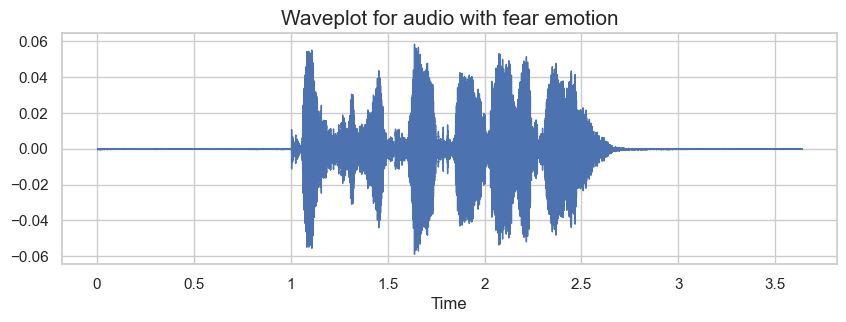

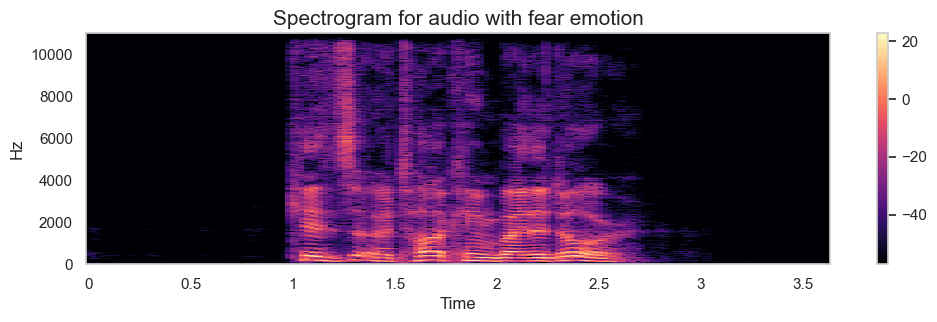

In [262]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

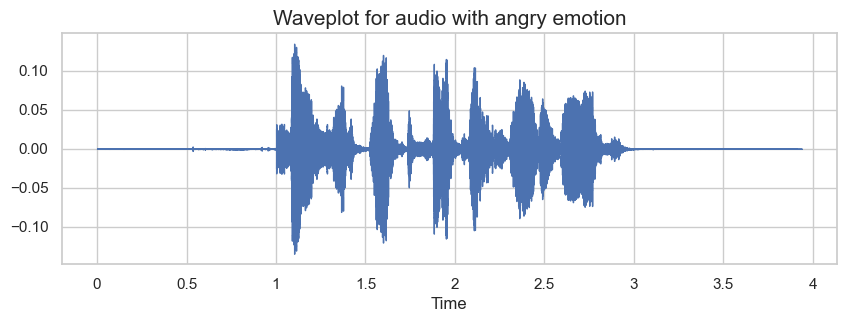

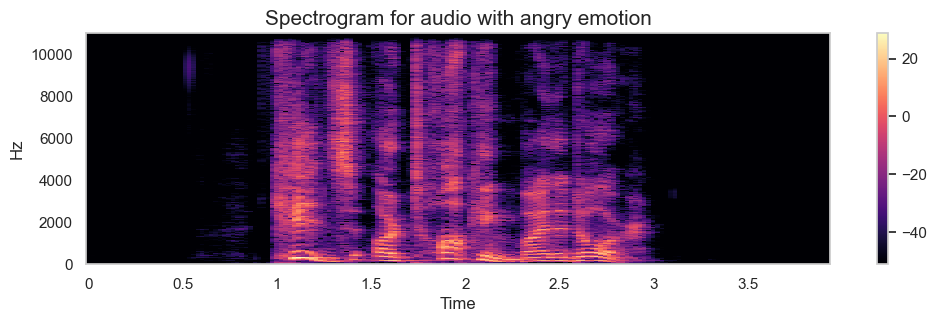

In [263]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

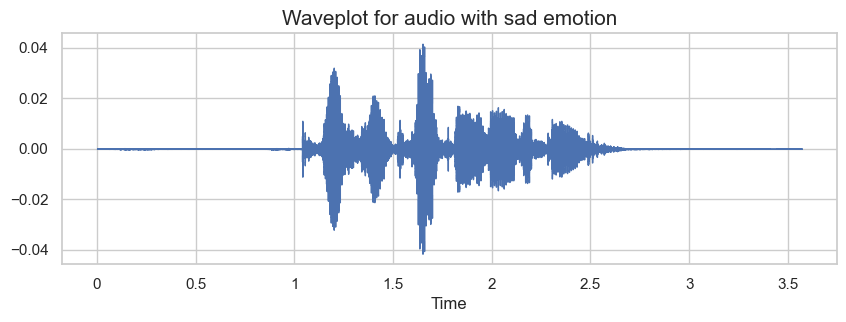

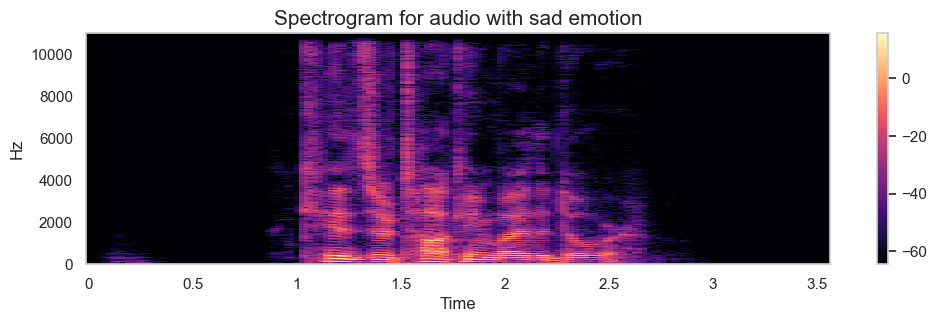

In [264]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

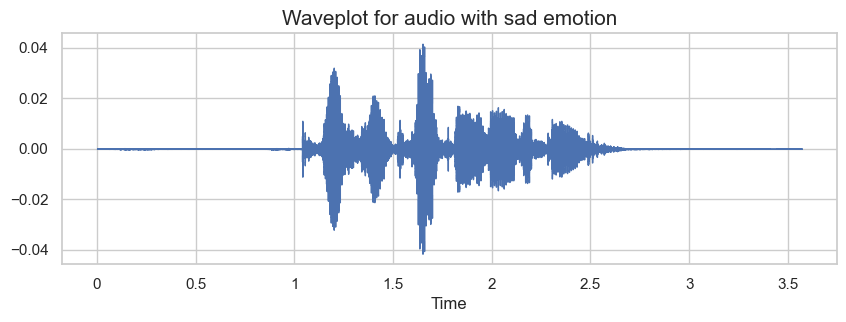

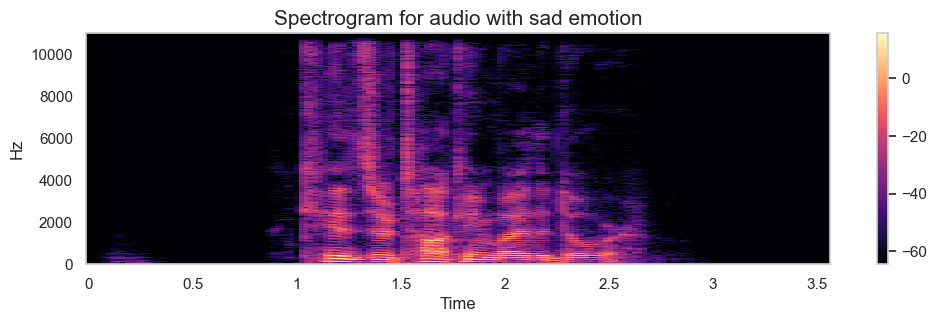

In [265]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

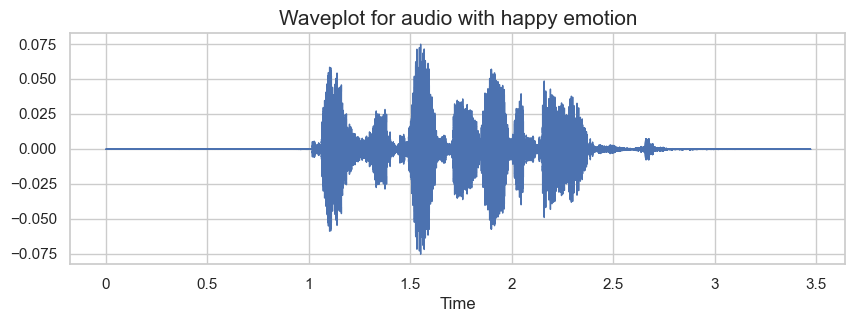

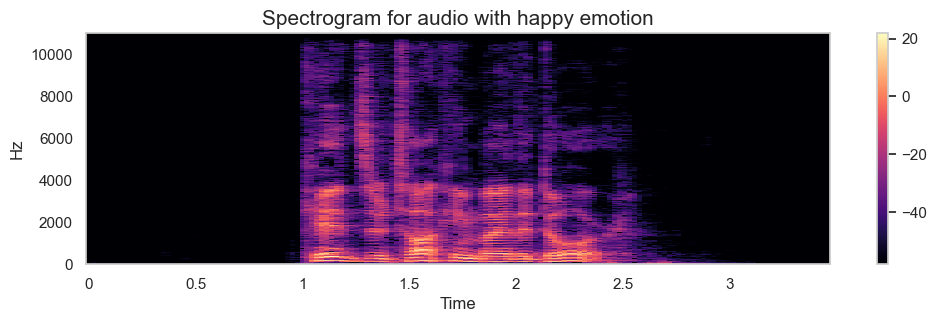

In [266]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [267]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, r):
    r = librosa.get_duration(y=data,sr=r)
    r = 7/r
    return librosa.effects.time_stretch(data, rate = r)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = 13)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [268]:
#simple audio

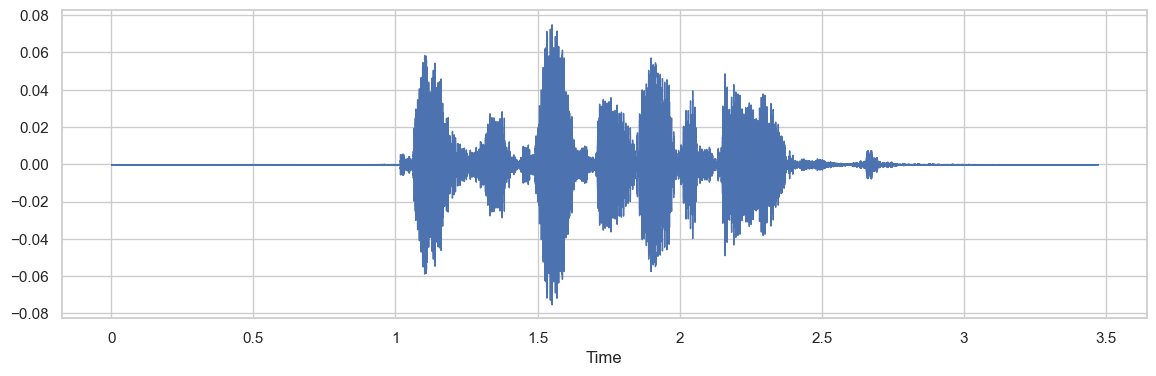

In [269]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

In [270]:
#with noise

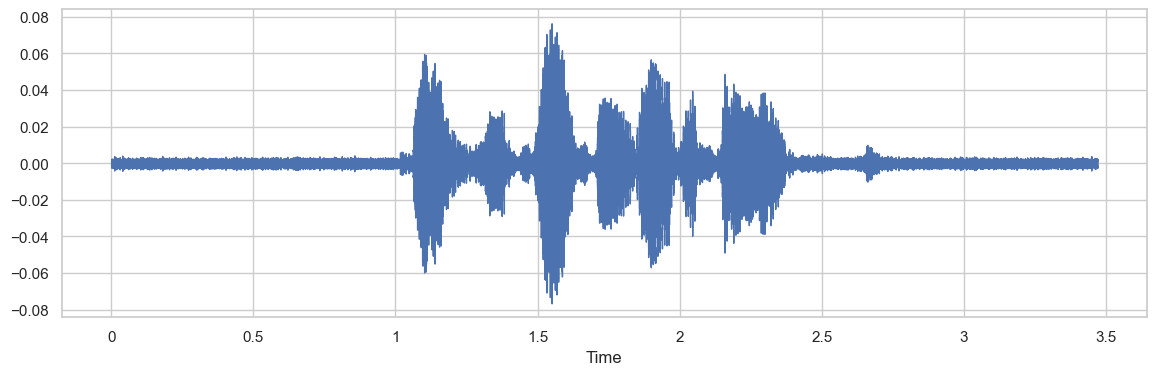

In [271]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [272]:
#shifitng

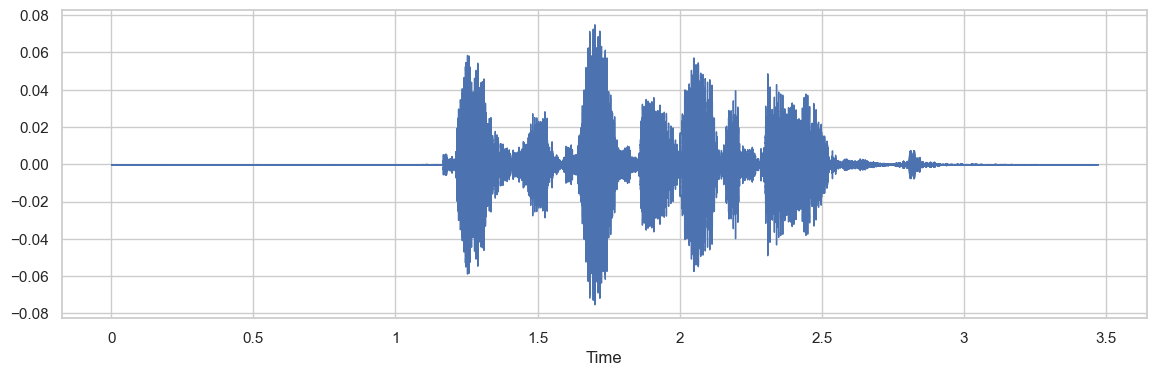

In [273]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [274]:
#pitch

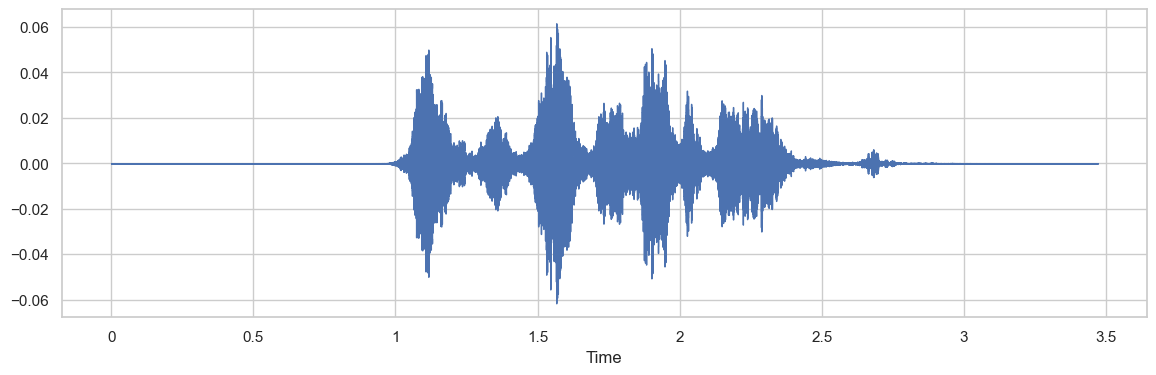

In [275]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [276]:
#strectching

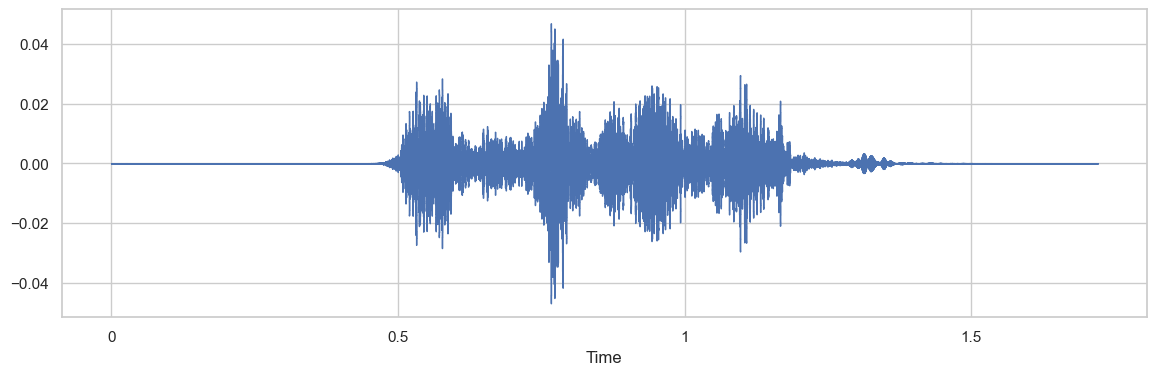

In [277]:
x = stretch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [278]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    new_data = stretch(data,sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [279]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [280]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.267546  0.688829  0.730021  0.708485  0.706601  0.734002  0.700951   
1  0.306075  0.778857  0.827299  0.812427  0.801132  0.833597  0.782509   
2  0.167255  0.672963  0.739469  0.767562  0.660835  0.627606  0.728561   
3  0.204187  0.697181  0.686450  0.690078  0.706820  0.673175  0.659655   
4  0.262650  0.749769  0.745835  0.751957  0.791475  0.793904  0.733682   

          7         8         9  ...       153       154       155       156  \
0  0.615528  0.637450  0.679339  ...  0.000014  0.000009  0.000015  0.000010   
1  0.647997  0.646829  0.695961  ...  0.000293  0.000288  0.000282  0.000271   
2  0.692964  0.531069  0.520021  ...  0.000018  0.000007  0.000011  0.000009   
3  0.657918  0.687829  0.682273  ...  0.000018  0.000013  0.000009  0.000006   
4  0.638564  0.659179  0.683824  ...  0.000072  0.000068  0.000067  0.000065   

        157       158       159       160           161  labels  
0  0.000013  0.000016  0.000012  0.000011  1.123394e-06   happy  
1  0.000278  0.000289  0.000272  0.000266  2.753734e-04   happy  
2  0.000009  0.000013  0.000012  0.000005  5.145769e-07   happy  
3  0.000004  0.000004  0.000004  0.000005  5.001726e-07   happy  
4  0.000066  0.000065  0.000067  0.000062  5.925877e-05   happy  

[5 rows x 163 columns]

In [281]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [282]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [283]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18774, 162), (18774, 5), (6258, 162), (6258, 5))

In [284]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18774, 162), (18774, 5), (6258, 162), (6258, 5))

In [285]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18774, 162, 1), (18774, 5), (6258, 162, 1), (6258, 5))

In [288]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 21, 128)         

In [289]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
294/294 [==============================] - 29s 89ms/step - loss: 1.3748 - accuracy: 0.3896 - val_loss: 1.1859 - val_accuracy: 0.4736 - lr: 0.0010
Epoch 2/50
294/294 [==============================] - 24s 83ms/step - loss: 1.2084 - accuracy: 0.4697 - val_loss: 1.0972 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 3/50
294/294 [==============================] - 28s 94ms/step - loss: 1.1355 - accuracy: 0.5094 - val_loss: 1.0256 - val_accuracy: 0.5655 - lr: 0.0010
Epoch 4/50
294/294 [==============================] - 24s 83ms/step - loss: 1.0476 - accuracy: 0.5542 - val_loss: 0.9610 - val_accuracy: 0.5837 - lr: 0.0010
Epoch 5/50
294/294 [==============================] - 27s 91ms/step - loss: 1.0002 - accuracy: 0.5741 - val_loss: 0.9246 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 6/50
294/294 [==============================] - 26s 87ms/step - loss: 0.9546 - accuracy: 0.5938 - val_loss: 0.8833 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 7/50
294/294 [==============================] - 26s 

196/196 [==============================] - 3s 15ms/step - loss: 0.9669 - accuracy: 0.6886
Accuracy of our model on test data :  68.85586380958557 %


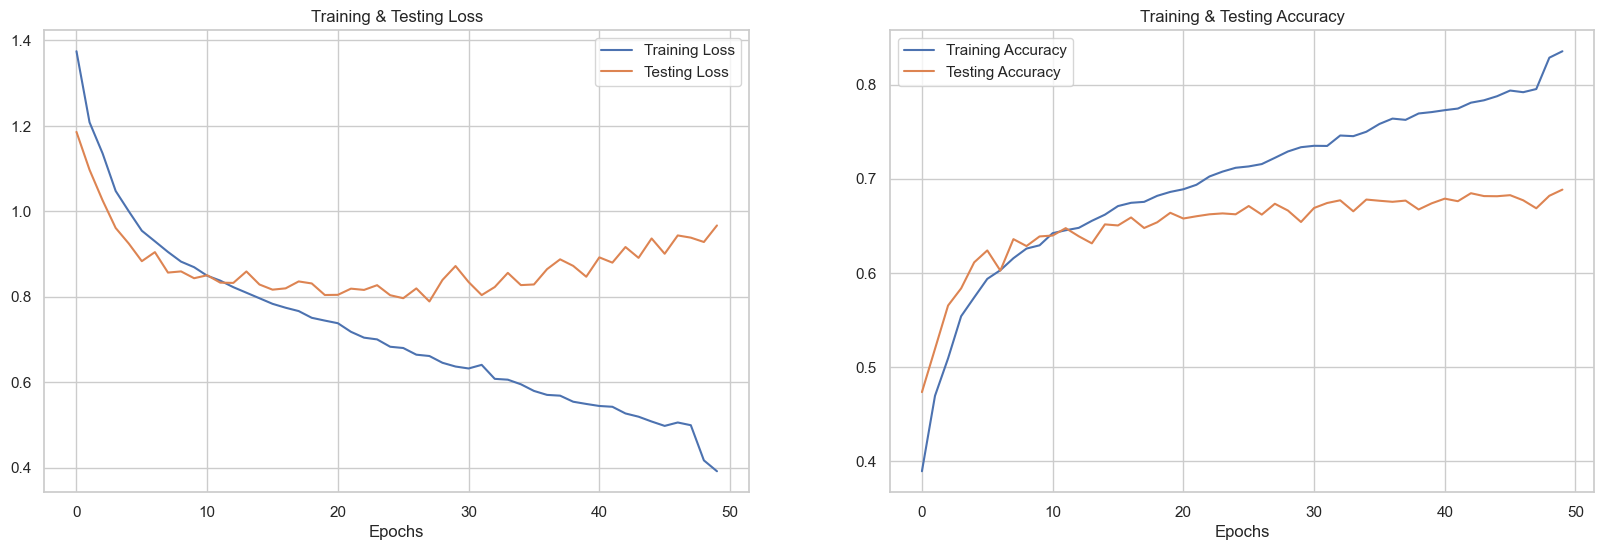

In [290]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [291]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

196/196 [==============================] - 3s 15ms/step


In [292]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad           sad
1            happy         happy
2            happy         happy
3            happy         happy
4              sad           sad
5             fear         angry
6             fear          fear
7         surprise          fear
8            happy         angry
9              sad      surprise

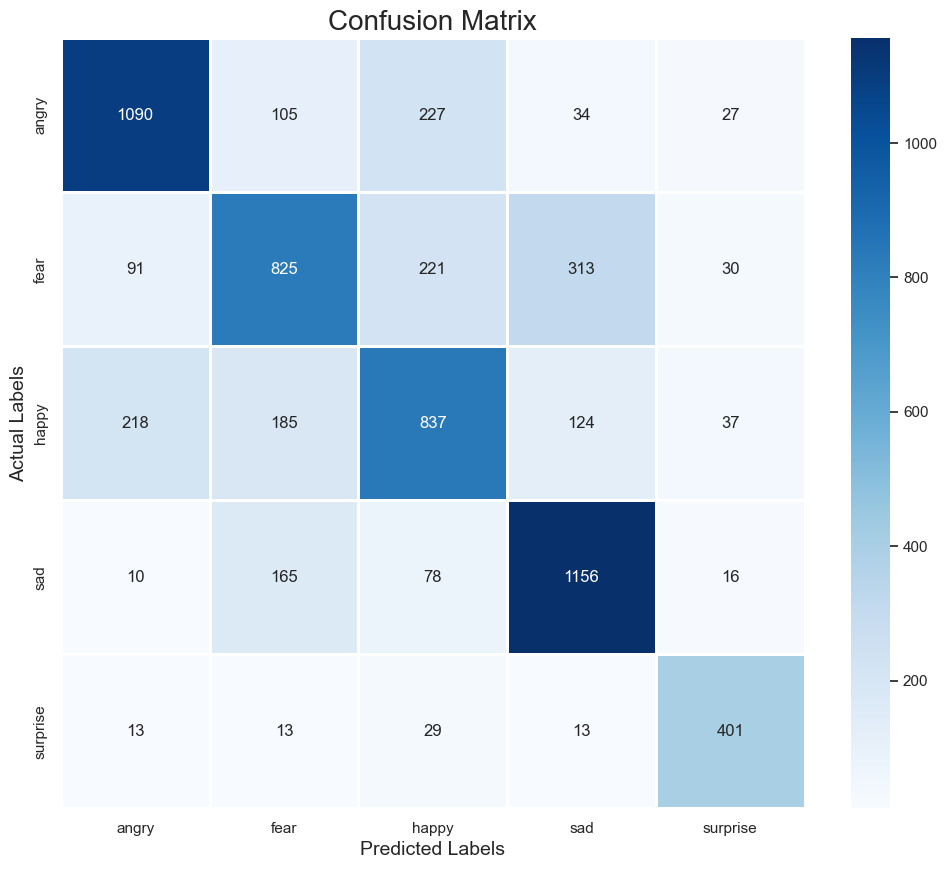

In [293]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [294]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.77      0.73      0.75      1483
        fear       0.64      0.56      0.60      1480
       happy       0.60      0.60      0.60      1401
         sad       0.70      0.81      0.75      1425
    surprise       0.78      0.86      0.82       469

    accuracy                           0.69      6258
   macro avg       0.70      0.71      0.70      6258
weighted avg       0.69      0.69      0.69      6258



In [217]:
#weighted model

In [227]:
import os
import speech_recognition as sr
from pydub import AudioSegment
import pandas as pd

recognizer = sr.Recognizer()

def audio_to_text(audio_file):
    if not audio_file.endswith(".wav"):
        sound = AudioSegment.from_file(audio_file)
        wav_file = audio_file.replace(audio_file.split('.')[-1], 'wav')
        sound.export(wav_file, format="wav")
        audio_file = wav_file
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
            print(text)
            return text
        except sr.UnknownValueError:
            return "Could not understand audio"
        except sr.RequestError:
            return "Could not request results; check your network connection"
data_path_subset = data_path.sample(n=500, random_state=42).copy()  # Set a random seed for reproducibility

data_path_subset['text'] = data_path_subset['Path'].apply(audio_to_text)

print(data_path_subset[['Path', 'text']])


don't forget jacket
the surface is flick
I think I've seen this before
say the word
who authorisation name the expense account
say the word
say the word
say the word
it's a weapon a clock
say the word cap
11:00
dogs are sitting by the door
dogs are sitting by the door
airplane is almost for
can you talking by the door
I would like a new alarm clock
11:00
dogs are sitting by the door
I am on my way to the meeting
say the word Birds
I think I have a doctor's appointment
say the word food
I think I have a doctor's appointment
say the word
I want to what this is about
say the word George
maybe tomorrow will be cold
it's 11:00
airplane is almost for
say the word
say the word
I would like a new alarm clock
the surface is sick
I would like a new alarm clock
it's 11:00
kids talking about the door
I am on my way to the meeting
I would like a new alarm clock
say the word
maybe tomorrow it will be cold
airplane is almost fall
I Wonder What this is about
the prospective cutting back spending is an

In [236]:
data_path_subset

emotion                                         audio_path  \
7056     fear   kaggle/input/cremad/AudioWAV/1087_IOM_FEA_XX.wav   
2606  disgust   kaggle/input/cremad/AudioWAV/1033_DFA_DIS_XX.wav   
6856    angry   kaggle/input/cremad/AudioWAV/1084_TSI_ANG_XX.wav   
5919    angry   kaggle/input/cremad/AudioWAV/1073_ITS_ANG_XX.wav   
1374      sad  kaggle/input/toronto-emotional-speech-set-tess...   
...       ...                                                ...   
2266  disgust   kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav   
1663  disgust  kaggle/input/toronto-emotional-speech-set-tess...   
4407  neutral   kaggle/input/cremad/AudioWAV/1054_WSI_NEU_XX.wav   
3270  disgust   kaggle/input/cremad/AudioWAV/1041_IEO_DIS_HI.wav   
1619  neutral   kaggle/input/cremad/AudioWAV/1020_WSI_NEU_XX.wav   

                                  text  
7056        Could not understand audio  
2606               don't forget jacket  
6856              the surface is flick  
5919     I think I've seen this before  
1374                      say the word  
...                                ...  
2266                 the surfaces like  
1663                 say the word home  
4407        Could not understand audio  
3270        Could not understand audio  
1619  will stop in a couple of minutes  

[500 rows x 3 columns]

In [235]:
data_path_subset = data_path_subset.rename(columns={'Path': 'audio_path', 'Emotions': 'emotion'})

In [326]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

class EmotionDataset(Dataset):
    def __init__(self, text_preds, audio_preds, labels):
        self.text_preds = torch.FloatTensor(text_preds)
        self.audio_preds = torch.FloatTensor(audio_preds)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'text_preds': self.text_preds[idx],
            'audio_preds': self.audio_preds[idx],
            'label': self.labels[idx]
        }

class MLPEnsemble(nn.Module):
    def __init__(self, num_emotions):
        super(MLPEnsemble, self).__init__()
        
        self.num_emotions = num_emotions
        
        self.text_layers = nn.Sequential(
            nn.Linear(num_emotions, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.audio_layers = nn.Sequential(
            nn.Linear(num_emotions, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.combine_layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, num_emotions)
        )
        
    def forward(self, text_preds, audio_preds):
        text_features = self.text_layers(text_preds)
        audio_features = self.audio_layers(audio_preds)
        combined = torch.cat([text_features, audio_features], dim=1)
        output = self.combine_layers(combined)
        return output

class AdvancedEmotionEnsemble:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.text_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
        self.audio_emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
        self.common_emotions = ['sadness', 'joy', 'anger', 'fear', 'surprise']
        
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.common_emotions)
        
        self.mlp = MLPEnsemble(len(self.common_emotions)).to(device)
    
    def _batch_tokenize(self, texts, batch_size=32):
        all_encodings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            encodings = self.tokenizer(
                batch_texts,
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )
            all_encodings.append({k: v.to(self.device) for k, v in encodings.items()})
        return all_encodings
    
    def _get_text_predictions(self, trainer, texts, batch_size=32):
        all_preds = []
        tokenized_batches = self._batch_tokenize(texts, batch_size)
        
        for batch_encodings in tokenized_batches:
            with torch.no_grad():
                outputs = trainer.model(**batch_encodings)
                logits = outputs.logits
                preds = logits.cpu().numpy()
                all_preds.append(preds)
        
        return np.vstack(all_preds)
    
    def _get_audio_predictions(self, cnn_model, audio_paths):
        X, Y = [], []
        for path in audio_paths:
            feature = get_features(path)
            for ele in feature:
                X.append(ele)
        f = pd.DataFrame(X)
        print(f)
        X = f.values
        scaler = StandardScaler()
        x = scaler.fit_transform(X)
        x = np.expand_dims(x, axis=2)
        print(x.shape)
        preds = cnn_model.predict(x)

        return preds
    
    def preprocess_data(self, df):
        valid_emotions = set(self.common_emotions)
        return df[df['emotion'].isin(valid_emotions)]
    
    def prepare_predictions(self, trainer, cnn_model, texts, audio_inputs, batch_size=32):
        text_preds = self._get_text_predictions(trainer, texts, batch_size)
        audio_preds = self._get_audio_predictions(cnn_model, audio_inputs)
        
        text_probs = self._convert_text_predictions(text_preds)
        audio_probs = self._convert_audio_predictions(audio_preds)
        
        return text_probs, audio_probs
    
    def _convert_text_predictions(self, text_preds):
        probs = self._softmax(text_preds)
        mapped_probs = np.zeros((probs.shape[0], len(self.common_emotions)))
        
        for i, emotion in enumerate(self.text_emotions):
            if emotion in self.common_emotions:
                mapped_idx = self.common_emotions.index(emotion)
                mapped_probs[:, mapped_idx] = probs[:, i]
        return mapped_probs
    
    def _convert_audio_predictions(self, audio_preds):
        mapped_probs = np.zeros((audio_preds.shape[0], len(self.common_emotions)))
        
        emotion_mapping = {
            'sad': 'sadness',
            'happy': 'joy',
            'angry': 'anger',
            'fear': 'fear',
            'surprise': 'surprise'
        }
        
        for i, emotion in enumerate(self.audio_emotions):
            if emotion in emotion_mapping:
                mapped_idx = self.common_emotions.index(emotion_mapping[emotion])
                mapped_probs[:, mapped_idx] = audio_preds[:, i]
        return mapped_probs
    
    def _softmax(self, x, axis=1):
        exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        return exp_x / np.sum(exp_x, axis=axis, keepdims=True)
    
    def train(self, trainer, cnn_model, train_df, val_df, 
              batch_size=32, num_epochs=50, learning_rate=0.001):
        self.trainer = trainer
        self.cnn_model = cnn_model
        
        print("Processing training data...")
        train_text_probs, train_audio_probs = self.prepare_predictions(
            trainer, cnn_model, 
            train_df['text'].tolist(), 
            train_df['audio_path'].tolist(),
            batch_size
        )
        train_labels = self.label_encoder.transform(train_df['emotion'])
        
        print("Processing validation data...")
        val_text_probs, val_audio_probs = self.prepare_predictions(
            trainer, cnn_model,
            val_df['text'].tolist(),
            val_df['audio_path'].tolist(),
            batch_size
        )
        val_labels = self.label_encoder.transform(val_df['emotion'])
        
        train_dataset = EmotionDataset(train_text_probs, train_audio_probs, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        val_dataset = EmotionDataset(val_text_probs, val_audio_probs, val_labels)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.mlp.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)
        
        best_val_acc = 0
        best_state = None
        
        print("Starting training...")
        for epoch in range(num_epochs):
            self.mlp.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch in train_loader:
                text_preds = batch['text_preds'].to(self.device)
                audio_preds = batch['audio_preds'].to(self.device)
                labels = batch['label'].to(self.device)
                
                optimizer.zero_grad()
                outputs = self.mlp(text_preds, audio_preds)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            val_acc = self.evaluate(val_loader)
            scheduler.step(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = self.mlp.state_dict()
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train Loss: {train_loss/len(train_loader):.4f}')
            print(f'Train Acc: {100.*correct/total:.2f}%')
            print(f'Val Acc: {100.*val_acc:.2f}%')
            print('--------------------')
        
        self.mlp.load_state_dict(best_state)
        return best_val_acc
    
    def evaluate(self, data_loader):
        """Evaluate the model"""
        self.mlp.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in data_loader:
                text_preds = batch['text_preds'].to(self.device)
                audio_preds = batch['audio_preds'].to(self.device)
                labels = batch['label'].to(self.device)
                
                outputs = self.mlp(text_preds, audio_preds)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return correct / total
    
    def predict(self, texts, audio_inputs, batch_size=32):
        """Make predictions using the trained ensemble"""
        self.mlp.eval()
        
        text_probs, audio_probs = self.prepare_predictions(
            self.trainer,
            self.cnn_model,
            texts,
            audio_inputs,
            batch_size
        )
        
        text_tensor = torch.FloatTensor(text_probs).to(self.device)
        audio_tensor = torch.FloatTensor(audio_probs).to(self.device)
        
        with torch.no_grad():
            outputs = self.mlp(text_tensor, audio_tensor)
            probs = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)
        
        final_emotions = self.label_encoder.inverse_transform(predictions.cpu().numpy())
        return final_emotions, probs.cpu().numpy()

In [329]:

ensemble = AdvancedEmotionEnsemble()


clean_df = ensemble.preprocess_data(data_path_subset)


train_df, val_df = train_test_split(clean_df, test_size=0.2, random_state=42)

best_val_acc = ensemble.train(
    trainer=trainer,
    cnn_model=model,
    train_df=train_df,
    val_df=val_df,
    batch_size=32,
    num_epochs=50,
    learning_rate=0.001
)

print(f"Best validation accuracy: {best_val_acc:.3f}")



loading file vocab.txt from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_General_4L_312D\snapshots\34707a33cd59a94ecde241ac209bf35103691b43\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at C:\Users\Srimanth/.cache\huggingface\hub\models--huawei-noah--TinyBERT_General_4L_312D\snapshots\34707a33cd59a94ecde241ac209bf35103691b43\config.json
Model config BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_lay

Processing training data...
          0         1         2         3         4         5         6    \
0    0.048614  0.338731  0.348973  0.403402  0.472972  0.464850  0.469095   
1    0.188662  0.518286  0.535639  0.583464  0.587155  0.602916  0.554101   
2    0.110579  0.212632  0.245681  0.279726  0.297079  0.331918  0.474757   
3    0.050915  0.529819  0.643656  0.607129  0.441746  0.470852  0.610067   
4    0.057177  0.552309  0.673591  0.562072  0.449839  0.522647  0.617707   
..        ...       ...       ...       ...       ...       ...       ...   
235  0.072417  0.675116  0.717311  0.668451  0.669281  0.702974  0.742831   
236  0.077715  0.560438  0.574312  0.638639  0.665609  0.616533  0.547760   
237  0.134885  0.470098  0.374631  0.268329  0.351996  0.373464  0.436563   
238  0.205198  0.507061  0.477912  0.439527  0.533326  0.567371  0.577226   
239  0.200745  0.250270  0.202639  0.250791  0.177007  0.419403  0.634038   

          7         8         9    ...         